# Plotting in OptiWindNet

This notebook explains the main plotting functions available for a `WindFarmNetwork (wfn)` instance. There are **five primary plots** which become available in different stages:


- Plots available **immediately after initialization** of the `wfn` object:

    - `wfn.plot_location()`

    - `wfn.plot_navigation_mesh()`

    - `wfn.plot_available_links()`

- Plot available **after running the optimization** (`wfn.optimize()`):

    - `wfn.plot_selected_links()`
    - `wfn.plot()`

For most users, only `wfn.plot_location()` and `wfn.plot()` are typically needed, so we present these first.  
The remaining plots are more relevant for **debugging** and **development purposes**, and are discussed in the advanced section below.

👉 [Jump to advanced plotting details](#advanced-plotting-details)

---

## Plotting location and the optimized network

### Import required modules

In [101]:
from optiwindnet.api import WindFarmNetwork, load_repository

In [ ]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Create a sample network
In this example, the `WindFarmNetwork` is initialized using `load_repository()` functionality. For more details on this functionality look at this notebook:  [included-locations.ipynb](api_02-included-locations.ipynb)

In [102]:
locations = load_repository()
wfn = WindFarmNetwork(L = locations.neart, cables=7)

Initializing an intance of `WindFarmNetwork()` creates three graphs:
1. location (`L`)
2. navigation mesh (`P`)
3. available links (`A`)

Accordingly, the correspondant plots are available right after.

### Plot location (L):

`L` contains only the **raw location data**—such as turbine and substation coordinates, borders, and obstacles—**without any links or connections** between nodes.

As a result, `wfn.plot_location()` will appear as an **empty graph**, showing only the individual elements without network links/edges.

This plot is useful to make sure the `WindFarmNetwork()` instance is initialized properly, before running the optimization.

<Axes: >

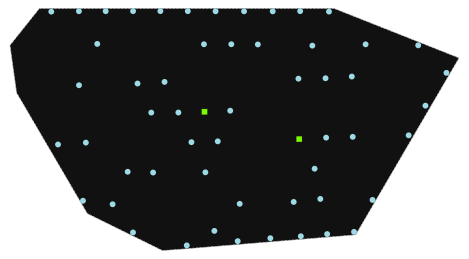

In [103]:
wfn.plot_location()

### Optimize

To plot and visualize the optimized network, an optimization needs to be performed first. For the sake of simplicity, we run the optimization with the default router in optiwindnet (i.e. `Heuristics-Esau_Williams`).

In [104]:
res = wfn.optimize()

### Plot the Optimized Network Graph
The optimized network graph (G) represents the optimized network with actual routes.

Accordingly, `wfn.plot()` displays the routes for selected links in the **optimized network**. The detoured routes are displayed via dashed lines. Detours are the routes created to resolve crossing feeders.

<Axes: >

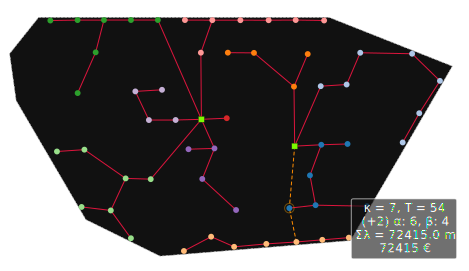

In [105]:
wfn.plot()

### Plot in a pre-existing axes

It is also possible to provide a pre-existing `plt.Axes` object within a matplotlib figure:

<Axes: >

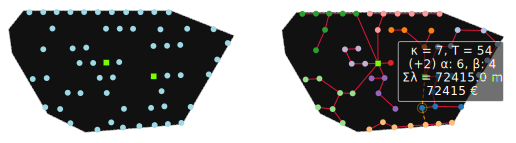

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='none', figsize=(9, 3))

wfn.plot_location(ax=ax1)
wfn.plot(ax=ax2)

### Plotting properties

Plotting properties, such as node tags and legends, can be modified by the user.


In OptiWindNet, **node tags** (labels) are used to identify turbines and substations in plots and outputs. These tags can be:

- **Automatically generated** by OptiWindNet
- **Manually provided** via `.yaml` files
  *(Note: tags in `.pbf` files are currently **not** supported.)*


Tag Generation Logic of OptiWindNet is as follows:

1. For turbine nodes (non-negative indices):

    - Tags are generated using a **base-50 encoding** with a custom alphabet of 50 characters:
  `'abcdefghijkmnopqrstuvwxyzABCDEFGHJKLMNOPQRSTUVWXYZ'`
  (Digits `'I'` and `'l'` are skipped to avoid confusion.)
    - This produces tags such as: `'a'`, `'b'`, ..., `'Z'`, `'aa'`, `'ab'`, ..., up to `'ZZ'`.
    - With two characters, up to **2500 unique turbine tags** can be generated.
    - These are assigned in the **order the turbines appear** in the input.

2. For substations (negative indices):

    - Tags are assigned using **Greek lowercase letters** starting from `'α'` (`alpha`), `'β'`, `'γ'`, etc.

This logic allows easy distinction between turbines and substations in plots.

Note that:

- The default **circle (turbine)** and **rectangle (substation)** plot symbols are sized to fit **two-character tags** comfortably using the current font size.
- Therefore, it is **recommended to limit manual tags to two characters** when defining them in `.yaml` files.


<Axes: >

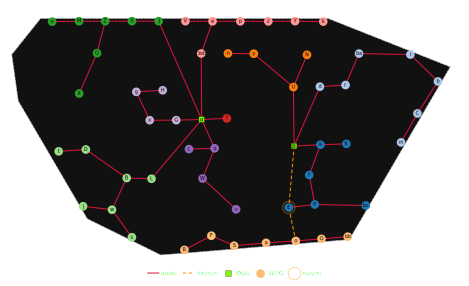

In [107]:
wfn.plot(node_tag='label', infobox=False, legend=True)

The nodes can also be tagged by the power they export towards the substation:

<Axes: >

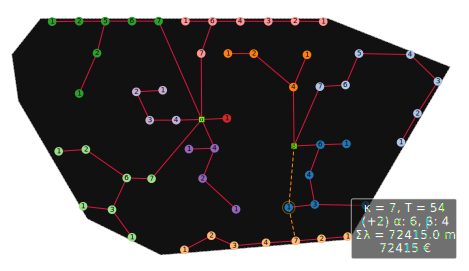

In [108]:
wfn.plot(node_tag='load')

### Theme of plots

The plots are visualized trying to match the colors used in the figure to the operating system's theme via Python package `darkdetect`. This package detects the system's theme and not JupyterLab's theme, so it may lead no non-ideal results if they do not match.

The example notebooks are created from a dark-themed system, but the figures might have a light background when the notebooks are run on a different computer.

The theme can be enforced programmatically by setting the argument `dark` to `True` or `False`:

<Axes: >

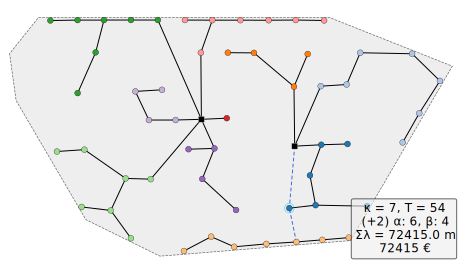

In [109]:
wfn.plot(dark=False)

### Rotated locations

Each location included in OptiWindNet has a graph attribute called `landscape_angle`.

In [110]:
wfn.L.graph['landscape_angle']

59.70466114754597

This is the angle that will rotate the site to be in the best orientation for a landscape figure. If the user prefers the orientation to be with the north always up, the argument `landscape` can be used. Alternatively, 'landscape_angle' could be set to 0.

<Axes: >

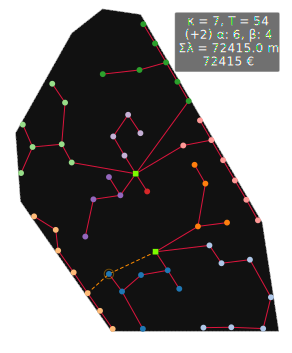

In [111]:
wfn.plot(landscape=False)

## Advanced Plotting Details


As mentioned at the begining, there are **five primary plots** which become available in different stages:

- Plots available **immediately after initialization** of the `wfn` object:

    - `wfn.plot_location()`
    → Displays turbine and substation locations, borders, and obstacles.

    - `wfn.plot_navigation_mesh()`
    → Displays the triangulated navigation mesh (planar embedding).

    - `wfn.plot_available_links()`
    → Displays available links in the search space.

- Plot available **after running the optimization** (`wfn.optimize()`):

    - `wfn.plot_selected_links()`
    → Displays the **selected links** in the optimized network. A *link* represents an **abstract connection** between two nodes (e.g., turbine to substation), without considering the actual physical path.

    - `wfn.plot()`
    → Displays the **actual cable routes** for the selected links. A **route** is the **physical path** the cable takes through the site, including contours to respect borders/obstacles and **detours** to resolve crossing feeders.

Two plots (`wfn.plot_location()` and `wfn.plot()`) are presented above. The remaining plots (`navigation_mesh`, `available_links`, and `selected_links` which are more relevant for **debugging** and **development purposes**) are discussed in this section.


### Plot navigation mesh
The corresponding graph contains a mesh generated by **constrained Delaunay triangulation**, represented as a planar embedding—a graph that can be embedded in 2D without any crossing.

<Axes: >

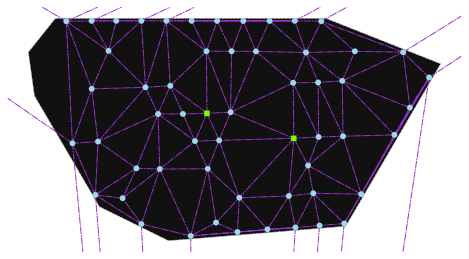

In [112]:
wfn.plot_navigation_mesh()

### Plot Available Links

The corresponding graph contains all **available links in the search space** derived from the **Delaunay triangulation**, and additional **diagonal links**.

The available link graph (A) is the primary graph used by downstream algorithms for **optimization**.

---

`wfn.plot_available_links()`

This plots displays the available links using different **line styles and colors** to distinguish link types:

* **Line format:**

  * **Solid lines**: direct Delaunay links
  * **Dashed lines**: diagonal or extended links

* **Line color:**

  * **Green**: unobstructed (valid) links
  * **Red**: obstructed links (e.g., crossing obstacles)


<Axes: >

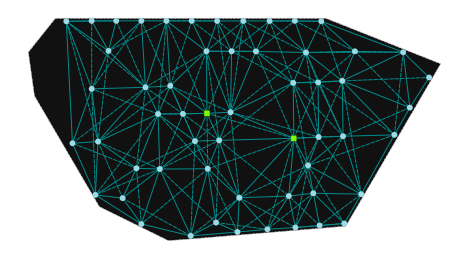

In [113]:
wfn.plot_available_links()

### Plot Selected Links

`wfn.plot_selected_links()` displays the **links selected** in the optimized network from among all available links.

<Axes: >

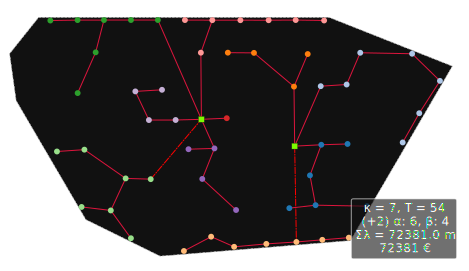

In [114]:
wfn.plot_selected_links()

To clarify the difference between `wfn.plot_selected_links()` and `wfn.plot()`, it's important to distinguish between a *link* and a *route*:

* A **link** is an **abstract connection** between two nodes (e.g., turbine to substation), without considering the actual physical path.
  *(Displayed by `wfn.plot_selected_links()`)*

* A **route** is the **physical path** the cable takes through the site, including contours to respect borders/obstacles and **detours** to resolve crossing-feeders.
  *(Displayed by `wfn.plot()`)*

>For a detailed explanation and visuals, read this paper:
>**To be added: \[link to paper]**